In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score,classification_report, confusion_matrix, f1_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor


In [2]:
filename3 = os.path.join(os.getcwd(),"dataframes", "actMath_11.csv")
actMath_11_df = pd.read_csv(filename3, header = 0)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [3]:
actMath_11_df.head(10)

,studentId,is_proficient,proficient_score,course_ACT Review,course_ACT/WK Rev.,course_ACTReview.5C,course_AG Communica,course_AIDE-ELEM,course_AIDE-LIB,course_ALG I B ACCE,course_ALIITRIGH/A,course_ARMY LET I,course_ARMY LET II,course_ARMY LET III,course_ARMY LET IV,course_ARMYLETIVACT,course_AcAdv.Baseba,course_AcAdv.Basket,course_AcAdv.CrossC,course_AcAdv.Footb,course_AcAdv.Softba,course_AcAdv.Volley,course_Accounting,course_Adv BTA,course_Advanced Agr,course_Agriscience,course_Alg Esntls B,course_Alg II/Trig,course_AlgEnrichmet,course_AlgII/TrigAC,course_Algebra I,course_Algebra I A,course_Algebra I B,course_Algebra II,course_AlgebraicCon,course_Anat/Physio,course_Anthropology,course_Art App,course_BAND MARCH,course_BANDCONCERT,course_BANDMARCHAUX,course_BIOLOGY ADV,course_Bak & Pstr A,course_BandConcer.5,course_BandConcer1C,course_BandMarch.5C,course_BandSymph 1C,course_Biology,course_Biology Adv,course_BullBogAdv,course_BulldogAdvi,course_Bus Finance,course_Bus Tech App,course_CABINETMAK I,course_CABINETMAKII,course_Cabntmkng I,course_Cabntmkng II,course_Career Prep,course_CareerPrep-A,course_CareerPrep-B,course_Chemistry,course_ChemistryAdv,course_Const Fin In,course_Const Frmng,course_ContempIss1C,course_Crea Writing,course_CreatWrt.5C,course_Credit Recov,course_Culinary I,course_Culinary II,course_D&TSafetyEd,course_DRIVERS ED,course_Dance 9-12,course_Digitl Dsgn,course_ESLEnrich912,course_ESLLang9-12,course_Ear/SpaceSci,course_Eng Ess 10,course_Eng Ess 11,course_Eng Gr10 Adv,course_EngGr9-CR,"course_EngLang,BS10",course_EnglGr10ACCE,course_English Gr 9,course_English Gr10,course_English Gr11,course_Enrichmt6-12,course_Enviro Sci,course_Ess II:USHis,course_Ess: E & SS,course_Ess: Phy Sci,course_EssIII:USHis,course_EssPhySci,course_EventPlan,course_FACS,course_FAM CON SC,course_Fit Life .5C,course_Fit/Cond,course_Food Inno,course_Food Nutritn,course_For/Cri Inve,course_Forestry,course_Found AAVTC,course_FrenchIACCE,course_Fund Agrisci,course_GEOM ADV,course_Geo Ess,course_Geometry,course_Geometry Adv,course_GeometryACCE,course_German1ACCES,course_Guitar,course_HEALTH 9-12,course_HEALTH ACCES,course_HISTUS1877AC,course_HS US 10 ADV,course_Health 9-12,course_HealthACCESS,course_Hosp Tourism,course_INFO SUP SVC,course_IT Fndamntls,course_IT Supp/Serv,course_Inet Mktg,course_Int Ad Desgn,course_Int Metl Fab,course_Inter Drftng,course_Intermed Agr,course_Intr Fire Sc,course_Intro Drftng,course_Jazz 1C,course_Journal1ACC,course_Journalism 1,course_LATIN 1 ACC,course_LAW IN SOCIE,course_LIFE PE 9-12,course_LIFEPE9-12.5,course_MARKET PRIN,course_MarchAux.5C,course_MarchAux1C,course_Marine Sci,course_Mktng Prin,course_Mnt Lt Rpr A,course_Mnt Lt Rpr B,course_Multimed Des,course_Multimed Pub,course_Music App,course_MusicTheatre,course_MusicTherI.5,course_MusicThry AP,course_MusicalDrama,course_Mustang Advi,course_NCCER ET1,course_NCCER ET2,course_NCCER Wldg1,course_NCCER Wldg2,course_Painting,course_Panther Adv,course_Per Finance,course_Percuss 1C,course_Phy Sci Adv,course_PhySciACCESS,course_Physical Sci,course_Piano .5C,course_Plumb/Pipe I,course_Plumb/PipeII,course_Prn Pub Serv,course_Psyc AP Acc,course_PsychACCESS,course_Psycholog.5C,course_Psychology,course_R/DinPhysics,course_RdIntrv7-12,course_Robotics App,course_SPAN II ACCE,course_SPANISH I,course_SPANISH II,course_Sociology,course_SociologyACC,course_Span2ACCESS,course_SpanIACC,course_Spanish 1,course_Spanish 2,course_Spanish 3,course_Speech 1,course_Spo&En Mktg,course_StuAiOff912,course_StudyHall912,course_TA-Partridge,course_Tech Theater,course_Theatre I,course_Theatre II,course_TmSpts,course_TmSpts-Dance,course_Tran Serv I,course_Tran Serv II,course_TranSer 11,course_TranSer El.5,course_TranSer10,course_Travl Tour I,course_US His-1877,course_USHis 1877-P,course_USHis I Adv,course_USHis I G10,course_USHis InD-P,course_USHisIG10ACC,course_VarBkbalI,course_VarBkbalII,course_VarBsbalI,course_VarBsbalII,course_VarBsblIV,course_VarCheerII,course_VarFBI,course_VarFBII,course

In [4]:
actMath_11_df[actMath_11_df.select_dtypes(include=['bool']).columns] = actMath_11_df.select_dtypes(include=['bool']).astype(int)
actMath_11_df.dtypes

studentId                 int64
is_proficient             int32
proficient_score        float64
course_ACT Review         int32
course_ACT/WK Rev.        int32
course_ACTReview.5C       int32
course_AG Communica       int32
course_AIDE-ELEM          int32
course_AIDE-LIB           int32
course_ALG I B ACCE       int32
course_ALIITRIGH/A        int32
course_ARMY LET I         int32
course_ARMY LET II        int32
course_ARMY LET III       int32
course_ARMY LET IV        int32
course_ARMYLETIVACT       int32
course_AcAdv.Baseba       int32
course_AcAdv.Basket       int32
course_AcAdv.CrossC       int32
course_AcAdv.Footb        int32
course_AcAdv.Softba       int32
course_AcAdv.Volley       int32
course_Accounting         int32
course_Adv BTA            int32
course_Advanced Agr       int32
course_Agriscience        int32
course_Alg Esntls B       int32
course_Alg II/Trig        int32
course_AlgEnrichmet       int32
course_AlgII/TrigAC       int32
course_Algebra I          int32
course_A

Training 

In [5]:
y_Math= actMath_11_df['proficient_score']
X_Math= actMath_11_df.drop(['proficient_score', 'is_proficient', 'studentId'], axis=1)
print("Number of examples: " + str(X_Math.shape[0]))
X_train_Math,X_test_Math, y_train_Math,y_test_Math = train_test_split(X_Math,y_Math, test_size=0.20,stratify=actMath_11_df['is_proficient'], random_state=123)
print(X_train_Math.shape)
print(X_test_Math.shape)


Number of examples: 2580
(2064, 238)
(516, 238)


In [6]:
'''
max_depth_values_math = [18,23,32]
n_estimators_value_math = [100,250,300,350]
param_grid = {'max_depth' : list(max_depth_values_math), 'n_estimators' : list(n_estimators_value_math)}

print("Running Grid Search")
rf_regressorMath = RandomForestRegressor()

# will have a 3-fold cross validation 
rf_gridMath = GridSearchCV(rf_regressorMath, param_grid, cv=3, scoring='neg_root_mean_squared_error')
rf_grid_searchMath = rf_gridMath.fit(X_train_Math, y_train_Math)

print("Done")
rf_best_paramsMath = rf_grid_searchMath.best_params_

rf_best_paramsMath

#{'max_depth': 32, 'n_estimators': 250}
'''


'\nmax_depth_values_math = [18,23,32]\nn_estimators_value_math = [100,250,300,350]\nparam_grid = {\'max_depth\' : list(max_depth_values_math), \'n_estimators\' : list(n_estimators_value_math)}\n\nprint("Running Grid Search")\nrf_regressorMath = RandomForestRegressor()\n\n# will have a 3-fold cross validation \nrf_gridMath = GridSearchCV(rf_regressorMath, param_grid, cv=3, scoring=\'neg_root_mean_squared_error\')\nrf_grid_searchMath = rf_gridMath.fit(X_train_Math, y_train_Math)\n\nprint("Done")\nrf_best_paramsMath = rf_grid_searchMath.best_params_\n\nrf_best_paramsMath\n\n#{\'max_depth\': 32, \'n_estimators\': 250}\n'

In [7]:
print('Begin Random Forest ')
rf_model_Math = RandomForestRegressor(max_depth=32, n_estimators=250)
rf_model_Math.fit(X_train_Math,y_train_Math)
print('End')

Begin Random Forest 
End


In [8]:
y_rf_pred_Math = rf_model_Math.predict(X_test_Math)
rf_rmse_Math = mean_squared_error(y_test_Math, y_rf_pred_Math, squared=False)
rf_r2_Math = r2_score(y_test_Math, y_rf_pred_Math)

#trying to get f1 and accuracy score 
threshold = 1
y_rf_pred_Math_bool = y_rf_pred_Math >= threshold
y_test_Math_bool = y_test_Math >= threshold

print("threshold=", threshold)
# Print the classification report
print("\nClassification Report:")
print(classification_report(y_test_Math_bool, y_rf_pred_Math_bool))
print('[RF] Root Mean Squared Error: {0}'.format(rf_rmse_Math))
print('[RF] R2: {0}'.format(rf_r2_Math))        

threshold= 1

Classification Report:
              precision    recall  f1-score   support

       False       0.78      0.95      0.86       329
        True       0.87      0.52      0.65       187

    accuracy                           0.80       516
   macro avg       0.82      0.74      0.76       516
weighted avg       0.81      0.80      0.78       516

[RF] Root Mean Squared Error: 0.16904434187378217
[RF] R2: 0.5001550809476355


In [9]:
#looking at the micro score
micro_f1 = f1_score(y_test_Math_bool, y_rf_pred_Math_bool, average='micro')

print("Micro F1 Score:", micro_f1)

Micro F1 Score: 0.7984496124031008


Confusion Matrix:
[[314  15]
 [ 89  98]]


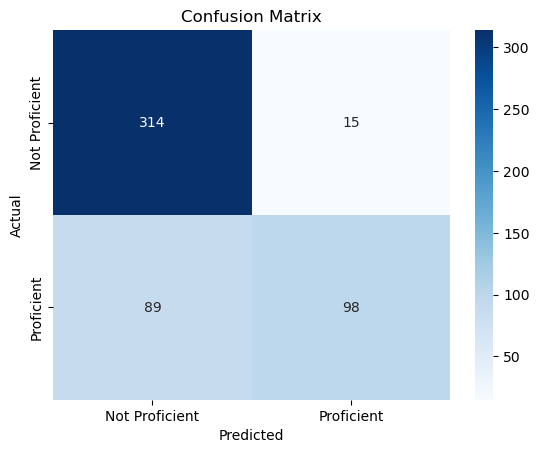

In [10]:
cm = confusion_matrix(y_test_Math_bool, y_rf_pred_Math_bool)

# Print the confusion matrix
print("Confusion Matrix:")
print(cm)

# Optionally, plot the confusion matrix using seaborn heatmap for better visualization
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Proficient", "Proficient"], yticklabels=["Not Proficient", "Proficient"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Feature Importance

In [11]:
importances = rf_model_Math.feature_importances_
feature_names = X_train_Math.columns

# Combine names and importances, and sort
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df= importance_df.sort_values(by='Importance', ascending=False)

# Display the sorted DataFrame
print(importance_df)

                  Feature    Importance
58    course_ChemistryAdv  2.663493e-01
84      course_Enviro Sci  3.783648e-02
156    course_Phy Sci Adv  2.388640e-02
29     course_Algebra I B  2.209493e-02
40    course_BandConcer.5  1.671086e-02
177      course_Spanish 1  1.664535e-02
131   course_LIFE PE 9-12  1.287887e-02
128   course_Journalism 1  1.282149e-02
123   course_Intermed Agr  1.281726e-02
82    course_English Gr11  1.232681e-02
208         course_VarFBI  1.189036e-02
163    course_Psyc AP Acc  1.187346e-02
229   course_Yearbook9-12  1.165846e-02
9      course_ARMY LET II  1.072885e-02
209        course_VarFBII  1.043415e-02
140   course_Multimed Des  1.017523e-02
218     course_VisArtI.5C  1.004329e-02
105   course_Geometry Adv  9.574588e-03
171      course_SPANISH I  9.227408e-03
76    course_Eng Gr10 Adv  9.105967e-03
215     course_Vis Arts I  9.010485e-03
152       course_Painting  8.854612e-03
146   course_MusicalDrama  8.517944e-03
183   course_StudyHall912  8.389542e-03


In [12]:
importance_df.head(10)

,Feature,Importance
58,course_ChemistryAdv,0.266349
84,course_Enviro Sci,0.037836
156,course_Phy Sci Adv,0.023886
29,course_Algebra I B,0.022095
40,course_BandConcer.5,0.016711
177,course_Spanish 1,0.016645
131,course_LIFE PE 9-12,0.012879
128,course_Journalism 1,0.012821
123,course_Intermed Agr,0.012817
82,course_English Gr11,0.012327
